我们来重头实现朴素贝叶斯分类器，对于我们的问题，有两个连续特征，我们把它们当成独立的。既然朴素贝叶斯是生成模型，
我们先考虑正向的生成过程会自然一些。正向生成等价于从联合概率$P(X=x,Y=y,C=c)$中直接抽一个，也等价于先以类先验$P(C=c)$抽一个类，再由条件概率
$P(X=x,Y=y \mid C=c)$抽一组$(x,y)$。和以往一样，一个观测带一个隶属类隐变量。对于类的估计，可以考虑类的参数是随机变量，也可以直接估计后固定。
这里贝叶斯主要指隶属变量以后验概率处理。

$$
P(X=x,Y=y,C=c) = P(X=x,Y=y \mid C=c) P(C=c) \\
P(X=x,Y=y \mid C=c) = P(X=x \mid C=c) P(Y=y \mid C=c) = N(x,\mu_{c_x},\sigma_{c_x}) N(y,\mu_{c_y},\sigma_{c_y})
$$ 

后验可表示为
$$
P(C=c \mid X=x,Y=y) = \frac{P(X=x,Y=y,C=c)}{P(X=x,Y=y)} \propto P(X=x,Y=y \mid C=c)P(C=c) =
N(x,\mu_{c_x},\sigma_{c_x}) N(y,\mu_{c_y},\sigma_{c_y}) P(C=c) \\
\log P(C=c \mid X=x,Y=y) \propto -\frac{(x-\mu_{c_x})^2}{2\sigma_{c_x}} - \frac{(y-\mu_{c_y})^2}{2\sigma_{c_y}} + P(C=c)
$$

对于四个正态分布的参数我们可以分别以频率主义直接估计了

利用二值离散随机变量的特性，又有

$$
P(C=0 \mid X=x,Y=y) = \frac{P(C=0 \mid X=x,Y=y)}{P(C=0 \mid X=x,Y=y) + P(C=1 \mid X=x,Y=y)} \\
\log P(C=0 \mid X=x,Y=y) = \log P(C=0 \mid X=x,Y=y) - \log(P(C=0 \mid X=x,Y=y) + P(C=1 \mid X=x,Y=y))
$$

如果从二值取值转为离散的多值，可得到

$$
P(C=c_t \mid X=x,Y=y) = \frac{P(C=0 \mid X=x,Y=y)}{\sum_{i=1}^m P(C=c_i \mid X=x,Y=y)} = 
\frac{P(X=x,Y=y,C=c_t)}{\sum_{i=1}^m P(X=x,Y=y,C=c_i)} \\
\log P(C=c_t \mid X=x,Y=y) = \log P(X=x,Y=y,C=c_t) - \log(\sum_{i=1}^m P(X=x,Y=y,C=c_i )) =
\log P(C=c_t \mid X=x,Y=y) = \log P(X=x,Y=y,C=c_t) - \log(\sum_{i=1}^m \exp( \log P(X=x,Y=y,C=c_i )))
$$

上式最后一个模式就是所谓的`logsumexp`函数，最后一个变化是因为$\log P(.)$一般比$P(.)$好计算和有优良的数值特性，特别是对指数族来说。
正如sklearn在此的例子实现的一样https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/naive_bayes.py#L87
使用特定函数在此很有必要。此例子另一个值得注意的地方是它争取使用`_joint_log_likelihood`作为中间结算的工具，
这比计算出条件概率或直接计算比率要明显清晰一些。

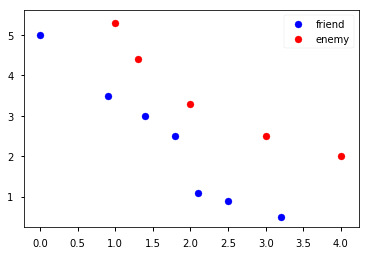

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import scipy.stats as stats
from scipy.special import logsumexp

friend_point = np.array([[0.0,5],[0.9,3.5],[1.4,3.0],[1.8,2.5],[2.1,1.1],[2.5,0.9],[3.2,0.5]])
enemy_point = np.array([[1.0,5.3],[1.3,4.4],[2.0,3.3],[3.0,2.5],[4.0,2.0]])

_x = np.linspace(-1,5,100)
_y = np.linspace(0,6,100)

xx,yy = np.meshgrid(_x,_y)

plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


In [2]:
X = np.vstack([friend_point, enemy_point])
Y = np.ones(X.shape[0],dtype=int)
Y[:friend_point.shape[0]] = 0

X,Y

(array([[0. , 5. ],
        [0.9, 3.5],
        [1.4, 3. ],
        [1.8, 2.5],
        [2.1, 1.1],
        [2.5, 0.9],
        [3.2, 0.5],
        [1. , 5.3],
        [1.3, 4.4],
        [2. , 3.3],
        [3. , 2.5],
        [4. , 2. ]]), array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))

In [3]:
friend_mu_xy = friend_point.mean(axis=0)
friend_sd_xy = friend_point.std(axis=0)
enemy_mu_xy = enemy_point.mean(axis=0)
enemy_sd_xy = enemy_point.std(axis=0)

In [4]:
friend_mu_xy

array([1.7       , 2.35714286])

In [5]:
def norm_log_prob(X,mu,sd,drop_constant = False):
    #这里好像弃掉和sigma相关的常数项好像是不对的，等会看看.确实，参见，实际实验也显示这样将得到不一样的结果
    #https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/naive_bayes.py#L425
    
    temp = -(X - mu)**2/(2*sd) 
    if not drop_constant:
        temp = temp - 0.5 * np.log(2.0 * np.pi * sd)
    return temp

In [6]:
PC = np.ones(2)/2
logPC = np.log(PC)

In [7]:
friend_log_likelihood = norm_log_prob(X,friend_mu_xy,friend_sd_xy).sum(axis=1) + logPC[0]
enemy_log_likelihood = norm_log_prob(X,enemy_mu_xy,enemy_sd_xy).sum(axis=1) + logPC[1]

In [8]:
friend_log_likelihood

array([-6.52216513, -3.48527124, -2.90733646, -2.73596259, -3.33065174,
       -3.7565594 , -5.02074712, -5.85008927, -4.19146993, -3.0652717 ,
       -3.595847  , -5.47402745])

In [9]:
enemy_log_likelihood

array([-5.90966011, -3.51256283, -3.115386  , -3.18688932, -5.06737533,
       -5.49447357, -6.79119208, -4.73152667, -3.42852197, -2.72581274,
       -3.3383452 , -4.97207613])

In [10]:
cp = np.c_[friend_log_likelihood,enemy_log_likelihood]

In [11]:
log_predict_prob = (cp.T - logsumexp(cp,axis=1)).T

In [12]:
np.exp(log_predict_prob)

array([[0.35148798, 0.64851202],
       [0.50682248, 0.49317752],
       [0.55182558, 0.44817442],
       [0.61085955, 0.38914045],
       [0.85027042, 0.14972958],
       [0.85042193, 0.14957807],
       [0.854513  , 0.145487  ],
       [0.246278  , 0.753722  ],
       [0.31800658, 0.68199342],
       [0.41594091, 0.58405909],
       [0.43597792, 0.56402208],
       [0.37708221, 0.62291779]])

In [13]:
def norm_naive_bayes_predict(X,mu,sd,logPC):
    # X: sample_size * features
    # mu: class_size * features
    # sd: class_size * featrues
    # log_PC class_size
    n_class = logPC.shape[0]
    n_feature = X.shape[1]
    n_sample = X.shape[0]
    _X = np.tile(X,[1,n_class]).reshape([n_sample,n_class,n_feature])
    cp = norm_log_prob(_X,mu,sd).sum(axis=2) + logPC  
    log_predict_prob = (cp.T - logsumexp(cp,axis=1)).T
    return log_predict_prob
    

In [14]:
mu = np.array([friend_mu_xy,enemy_mu_xy])
sd = np.array([friend_sd_xy,enemy_sd_xy])

In [15]:
norm_naive_bayes_predict(X,mu,sd,logPC)

array([[-1.04557976, -0.43307474],
       [-0.67959448, -0.70688608],
       [-0.59452326, -0.8025728 ],
       [-0.49288821, -0.94381495],
       [-0.16220084, -1.89892443],
       [-0.16202266, -1.89993684],
       [-0.15722357, -1.92766852],
       [-1.40129428, -0.28273168],
       [-1.14568322, -0.38273526],
       [-0.87721208, -0.53775312],
       [-0.83016368, -0.57266188],
       [-0.97529204, -0.47334073]])

In [16]:
np.exp(_)

array([[0.35148798, 0.64851202],
       [0.50682248, 0.49317752],
       [0.55182558, 0.44817442],
       [0.61085955, 0.38914045],
       [0.85027042, 0.14972958],
       [0.85042193, 0.14957807],
       [0.854513  , 0.145487  ],
       [0.246278  , 0.753722  ],
       [0.31800658, 0.68199342],
       [0.41594091, 0.58405909],
       [0.43597792, 0.56402208],
       [0.37708221, 0.62291779]])

In [17]:
Z = norm_naive_bayes_predict(np.c_[xx.ravel(),yy.ravel()],mu,sd,logPC).reshape(xx.shape+(2,)) #注意这是对数概率

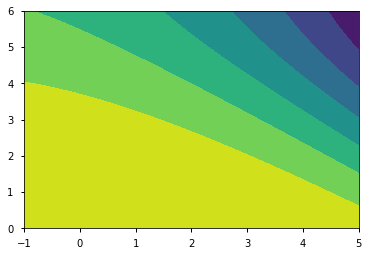

In [18]:
plt.contourf(xx,yy,Z[:,:,0]) 

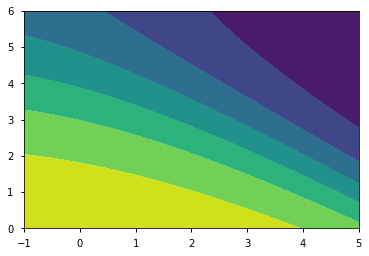

In [19]:
_logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)]))
Z = norm_naive_bayes_predict(np.c_[xx.ravel(),yy.ravel()],mu,sd,_logPC).reshape(xx.shape+(2,))
plt.contourf(xx,yy,np.exp(Z[:,:,0]))

In [20]:
_logPC

array([-0.5389965 , -0.87546874])

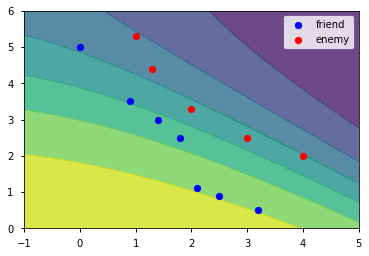

In [21]:
cm = plt.cm.RdBu
plt.contourf(xx, yy, np.exp(Z[:,:,0]), alpha=.8)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


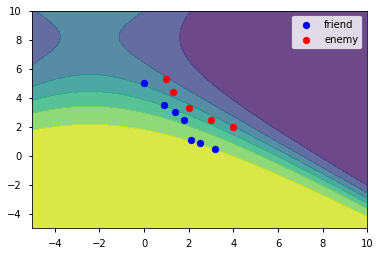

In [22]:
__x = np.linspace(-5,10,200)
__y = np.linspace(-5,10,200)
xxx,yyy = np.meshgrid(__x,__y)

_logPC = np.log(np.array([np.sum(Y==0)/len(Y),np.sum(Y==1)/len(Y)]))
ZZ = norm_naive_bayes_predict(np.c_[xxx.ravel(),yyy.ravel()],mu,sd,_logPC).reshape(xxx.shape+(2,))

cm = plt.cm.RdBu
plt.contourf(xxx, yyy, np.exp(ZZ[:,:,0]), alpha=.8)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


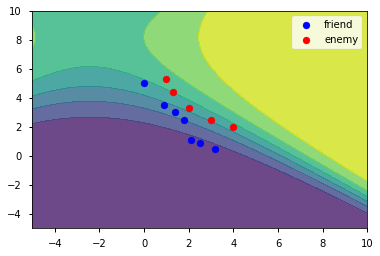

In [23]:

cm = plt.cm.RdBu
plt.contourf(xxx, yyy, np.exp(ZZ[:,:,1]), alpha=.8)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


In [24]:
import scipy
min_dis = scipy.spatial.distance.cdist(np.c_[xxx.ravel(),yyy.ravel()], X).min(axis=1).reshape(xxx.shape)
dis_factor = np.exp(-0.1*min_dis)

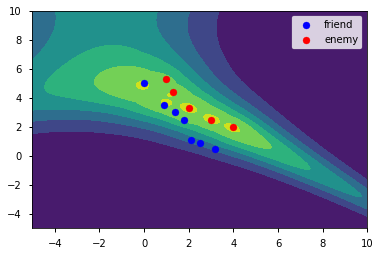

In [25]:
plt.contourf(xxx,yyy,np.exp(ZZ)[:,:,0]*np.exp(ZZ)[:,:,1] * dis_factor)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
plt.legend()
plt.show()


In [26]:
class GridSampler2d:
    def __init__(self,prob,x,y):
        # prob: n_sample * 2 -> n_sample
        self.prob = prob
        self.x,self.y = x,y
        self.x_step = x[1] - x[0]
        self.y_step = y[1] - y[0]
        xx, yy = np.meshgrid(x,y)
        self.xx,self.yy = xx,yy
        xy = np.c_[xx.ravel(),yy.ravel()]
        self.xy = xy
        _prob = prob(xy)
        self.grid_prob = _prob / _prob.sum()
    def sample(self, size):
        base = self.xy[np.random.choice(len(self.xy), size, p=self.grid_prob)]
        x_noise = stats.uniform(-self.x_step/2, self.x_step/2).rvs(size)
        y_noise = stats.uniform(-self.y_step/2, self.x_step/2).rvs(size)
        base[:,0] += x_noise
        base[:,1] += y_noise
        return base

In [27]:
def prob(xy):
    return norm_naive_bayes_predict(xy,mu,sd,logPC)[:,0]

In [28]:
sampler = GridSampler2d(prob,_x,_y)

In [29]:
sampler.sample(10)

array([[-0.7101194 ,  4.95314651],
       [ 4.00580236,  5.6949372 ],
       [ 3.47512544,  4.70752189],
       [ 2.78908419,  0.76117452],
       [ 4.30996562,  4.58696656],
       [ 4.86059983,  4.46267076],
       [ 4.6062953 ,  2.53218981],
       [ 1.6500352 ,  3.20202397],
       [-0.58445672,  3.43504025],
       [ 4.74889653,  2.59413447]])

In [30]:
min_dis = scipy.spatial.distance.cdist(np.c_[xx.ravel(),yy.ravel()], X).min(axis=1).reshape(xx.shape)
dis_factor = np.exp(-0.2*min_dis)

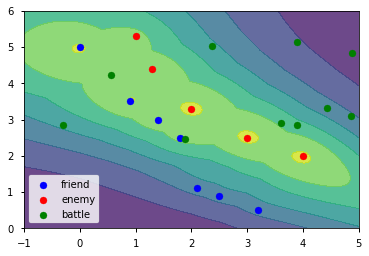

In [31]:
cm = plt.cm.RdBu
plt.contourf(xx, yy, np.exp(Z)[:,:,0]*np.exp(Z)[:,:,1] * dis_factor, alpha=.8)
plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
sample = sampler.sample(10)
plt.scatter(sample[:,0],sample[:,1],color='green',label='battle')
plt.legend()
plt.show()


In [32]:
def prob(xy, dis_factor,poly=1):
    Z = np.exp(norm_naive_bayes_predict(xy,mu,sd,logPC))
    ZZ = (Z[:,0] *Z[:,1]) * dis_factor
    ZZ = ZZ**poly
    return ZZ / ZZ.sum()

In [39]:
def show_sample(_x,_y,exp_factor=0.2,size=10,poly=1,hist=True):
    xx,yy = np.meshgrid(_x,_y)
    xy = np.c_[xx.ravel(),yy.ravel()]
    
    min_dis = scipy.spatial.distance.cdist(xy, X).min(axis=1)#.reshape(xx.shape)
    dis_factor = np.exp(-exp_factor*min_dis)
    
    
    #Z = norm_naive_bayes_predict(np.c_[xx.ravel(),yy.ravel()],mu,sd,_logPC).reshape(xx.shape+(2,))
    
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, prob(xy, dis_factor,poly=poly).reshape(xx.shape), alpha=.8)
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    sampler = GridSampler2d(lambda xy:prob(xy,dis_factor,poly=poly) ,_x,_y)
    sample = sampler.sample(size)
    plt.scatter(sample[:,0],sample[:,1],color='green',label='battle')
    plt.legend()
    plt.show()
    
    if hist:
        plt.hist(prob(np.c_[xx.ravel(),yy.ravel()],dis_factor,poly=poly))

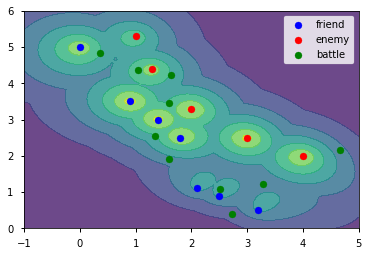

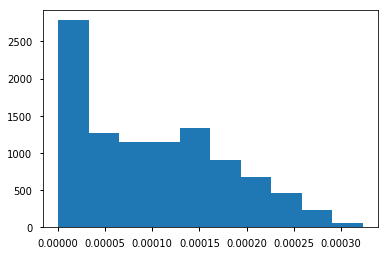

In [40]:
show_sample(_x,_y,exp_factor=1)

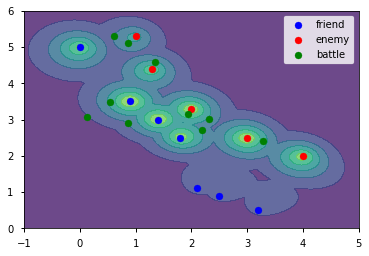

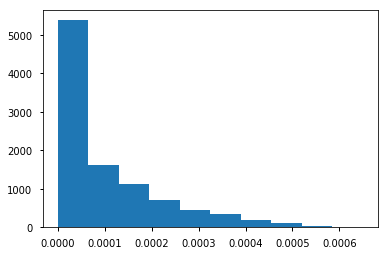

In [41]:
show_sample(_x,_y,exp_factor=1,poly=2)

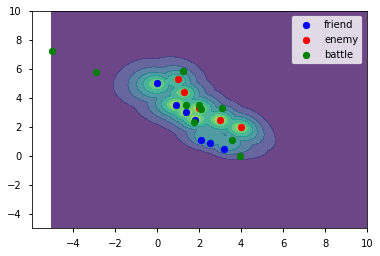

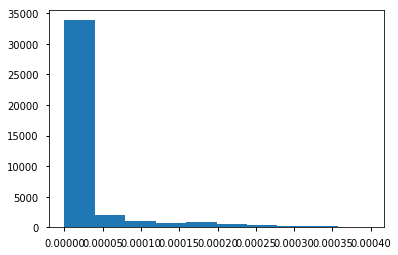

In [42]:
show_sample(__x,__y,exp_factor=1)

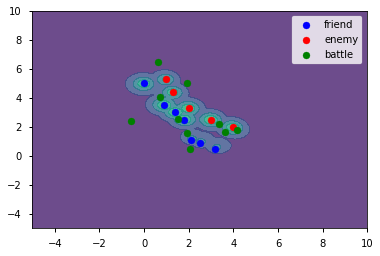

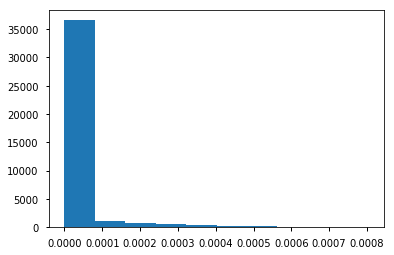

In [51]:
show_sample(__x,__y,exp_factor=2)

这怎么搞效果都不好。。决定直接加个截断了，我们根据争议度（双方概率之积）和距离分别加个截断。合法区域内部实行均匀概率。
之后考虑把截断soft化和合法区域内部分别加权的处理。

In [73]:
def prob(xy, conflict_threshold, distance_threshold):
    conflict = np.exp(norm_naive_bayes_predict(xy,mu,sd,logPC)).prod(axis=1)
    distance = scipy.spatial.distance.cdist(xy, X).min(axis=1)
    p = np.zeros(xy.shape[0])
    p[(conflict > conflict_threshold) & (distance < distance_threshold)] = 1
    return p / p.sum()

In [65]:
xy=np.c_[xx.ravel(),yy.ravel()]

In [66]:
conflict = np.exp(norm_naive_bayes_predict(xy,mu,sd,logPC)).prod(axis=1)

In [68]:
distance = scipy.spatial.distance.cdist(xy, X).min(axis=1)

In [71]:
p = np.zeros(xy.shape[0])

In [72]:
p[(conflict  > 0.1) & ]

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
def show_sample(_x,_y, conflict_threshold=0.1,distance_threshold=2.0, size=10,hist=True):
    xx,yy = np.meshgrid(_x,_y)
    xy = np.c_[xx.ravel(),yy.ravel()]
    _prob = lambda xy:prob(xy,conflict_threshold,distance_threshold)
    _prob_xy = _prob(xy)
            
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, _prob_xy.reshape(xx.shape), alpha=.8)
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    
    sampler = GridSampler2d(_prob ,_x,_y)
    sample = sampler.sample(size)
    plt.scatter(sample[:,0],sample[:,1],color='green',label='battle')
    plt.legend()
    plt.show()
    
    if hist:
        plt.hist(_prob_xy)

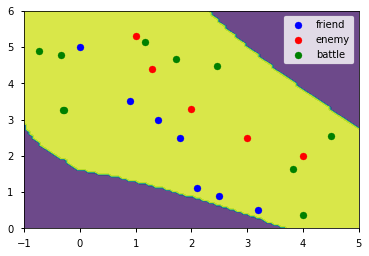

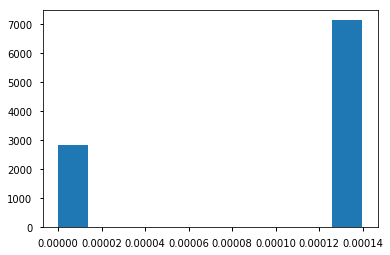

In [75]:
show_sample(_x,_y)

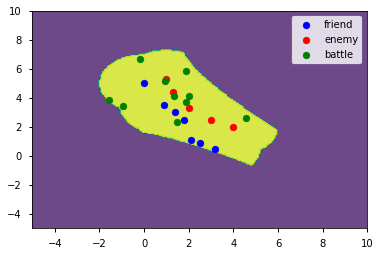

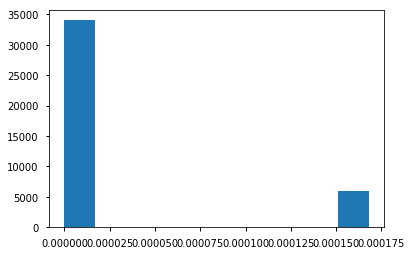

In [76]:
show_sample(__x,__y)

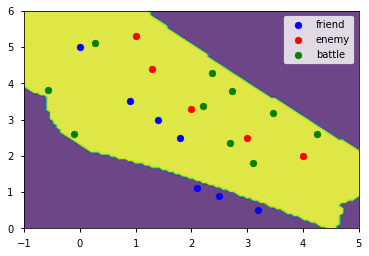

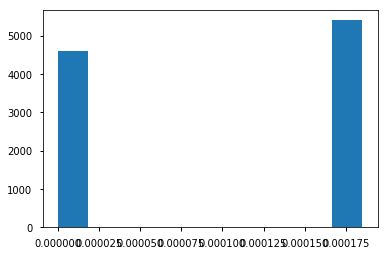

In [77]:
show_sample(_x,_y,conflict_threshold=0.15,distance_threshold=1.5)

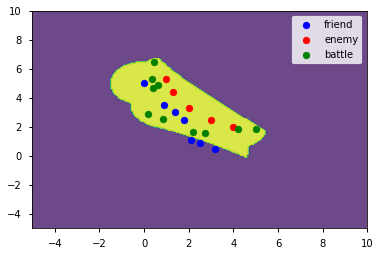

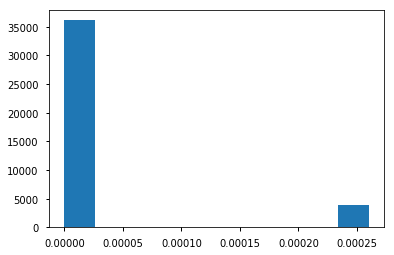

In [78]:
show_sample(__x,__y,conflict_threshold=0.15,distance_threshold=1.5)

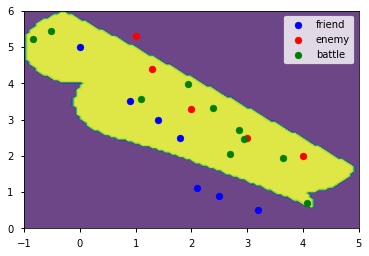

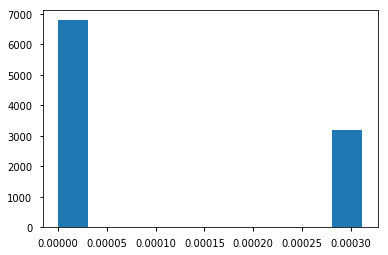

In [80]:
show_sample(_x,_y,conflict_threshold=0.2,distance_threshold=1.0)

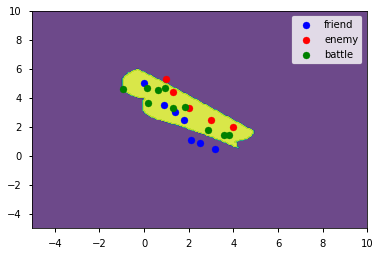

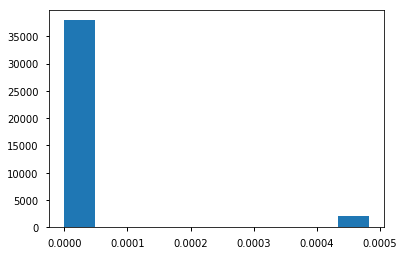

In [81]:
show_sample(__x,__y,conflict_threshold=0.2,distance_threshold=1.0)

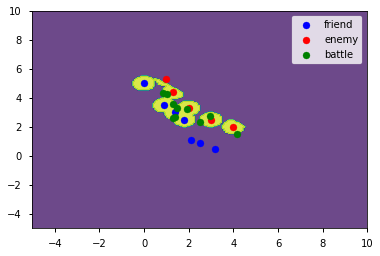

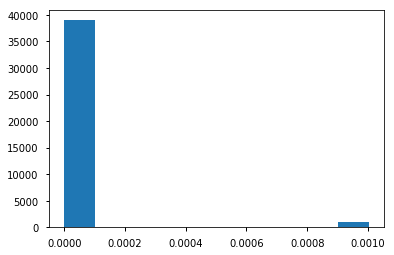

In [83]:
show_sample(__x,__y,conflict_threshold=0.2,distance_threshold=0.5)

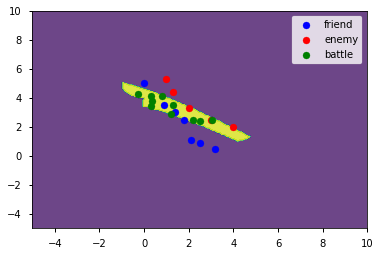

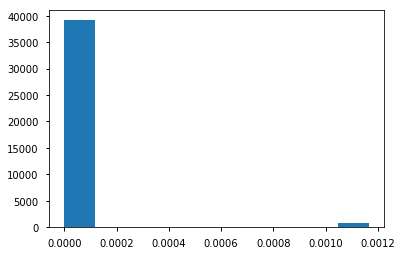

In [86]:
show_sample(__x,__y,conflict_threshold=0.24,distance_threshold=1.0)

In [94]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def soft_cut_ge(x,threshold,tense=1.0):
    return sigmoid(tense*(x-threshold))

def soft_cut_le(x,threshold,tense=1.0):
    return sigmoid(tense*(-x+threshold))


In [95]:
def prob(xy, conflict_threshold, distance_threshold,tense = 1.0):
    conflict = np.exp(norm_naive_bayes_predict(xy,mu,sd,logPC)).prod(axis=1)
    distance = scipy.spatial.distance.cdist(xy, X).min(axis=1)
    #p = np.zeros(xy.shape[0])
    #p[(conflict > conflict_threshold) & (distance < distance_threshold)] = 1
    p = soft_cut_ge(conflict,conflict_threshold, tense = tense) * soft_cut_le(distance, distance_threshold, tense = tense)
    return p / p.sum()

In [96]:
def show_sample(_x,_y, conflict_threshold=0.1,distance_threshold=2.0, tense=1.0, size=10,hist=True):
    xx,yy = np.meshgrid(_x,_y)
    xy = np.c_[xx.ravel(),yy.ravel()]
    _prob = lambda xy:prob(xy,conflict_threshold,distance_threshold, tense = tense)
    _prob_xy = _prob(xy)
            
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, _prob_xy.reshape(xx.shape), alpha=.8)
    plt.scatter(friend_point[:,0],friend_point[:,1],color='blue',label='friend')
    plt.scatter(enemy_point[:,0],enemy_point[:,1],color='red',label='enemy')
    
    sampler = GridSampler2d(_prob ,_x,_y)
    sample = sampler.sample(size)
    plt.scatter(sample[:,0],sample[:,1],color='green',label='battle')
    plt.legend()
    plt.show()
    
    if hist:
        plt.hist(_prob_xy)

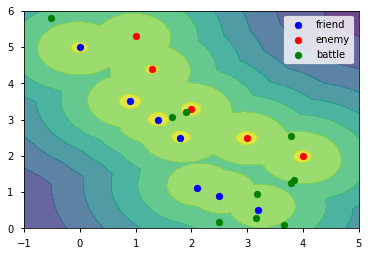

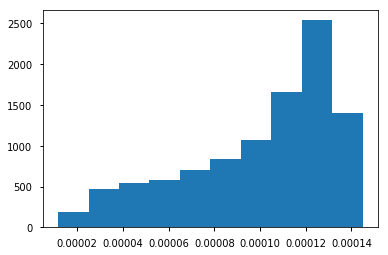

In [97]:
show_sample(_x,_y,conflict_threshold=0.15,distance_threshold=1.5)

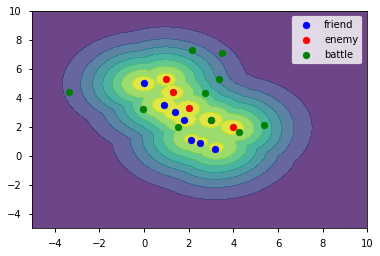

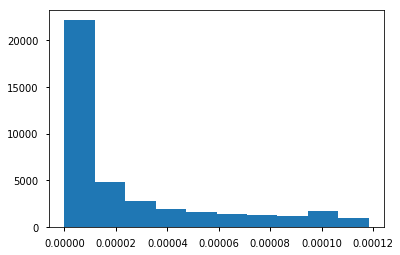

In [98]:
show_sample(__x,__y,conflict_threshold=0.15,distance_threshold=1.5)

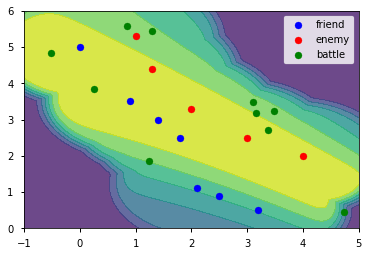

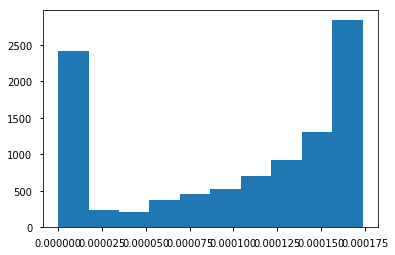

In [99]:
show_sample(_x,_y,conflict_threshold=0.15,distance_threshold=1.5,tense = 10.0)

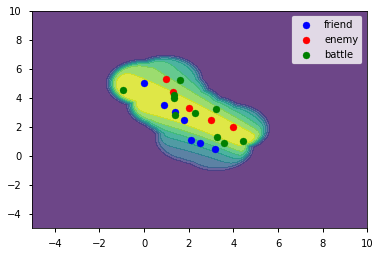

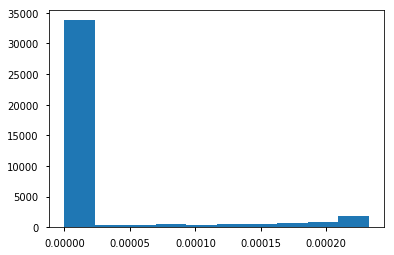

In [100]:
show_sample(__x,__y,conflict_threshold=0.15,distance_threshold=1.5,tense = 10.0)

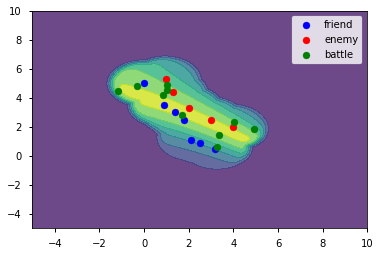

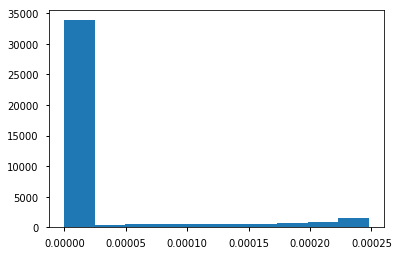

In [131]:
show_sample(__x,__y,conflict_threshold=0.2,distance_threshold=1.5,tense = 10.0)

In [114]:
def soft_max(x,order=3): # 这是对max的软化，不是那个同名的返回概率向量的函数
    return np.sum(x**order)**(1.0/order)

def soft_max2(x,order=3): # 这是对max的软化，不是那个同名的返回概率向量的函数
    return np.sum(x**order)**(1.0/order)

In [124]:
soft_max(np.array([2,3,6,4,2,6]),order=3)

8.138223044397701

看起来效果还行。。也比较好操纵，暂且就用这个了。